## Reference implementation of the Tic-Tac-Toe Value Function Learning Agent
### "Reinforcement Learning: An Introduction" Chapter One: Sutton and Barto, 2018

###### Self-Play: Suppose, instead of playing against a random opponent, the reinforcement learning algorithm described above played against itself, with both sides learning. 
- What do you think would happen in this case? 
- Would it learn a different policy for selecting moves?

The result is that the agent learns only how to maximize its own potential payoff, without consideration
for whether it is playing to a win or a draw. Even more to the point, the agent learns a myopic strategy
where it basically has a single path that it wants to take to reach a winning state. If the path is blocked
by the opponent, the values will then usually all become 0.5 and the player is effectively moving randomly.

In [1]:
import random
from copy import copy, deepcopy
import csv
import matplotlib.pyplot as plt

In [2]:
EMPTY = 0
PLAYER_X = 1
PLAYER_O = 2
DRAW = 3


BOARD_FORMAT = "----------------------------\n| {0} | {1} | {2} |\n|--------------------------|\n| {3} | {4} | {5} |\n|--------------------------|\n| {6} | {7} | {8} |\n----------------------------"
NAMES = [' ', 'X', 'O']
def printboard(state):
    cells = []
    for i in range(3):
        for j in range(3):
            cells.append(NAMES[state[i][j]].center(6))
    print(BOARD_FORMAT.format(*cells))


In [3]:
def emptystate():
    return [[EMPTY,EMPTY,EMPTY],[EMPTY,EMPTY,EMPTY],[EMPTY,EMPTY,EMPTY]]

In [4]:
def gameover(state):
    for i in range(3):
        if state[i][0] != EMPTY and state[i][0] == state[i][1] and state[i][0] == state[i][2]:
            return state[i][0]
        if state[0][i] != EMPTY and state[0][i] == state[1][i] and state[0][i] == state[2][i]:
            return state[0][i]
    if state[0][0] != EMPTY and state[0][0] == state[1][1] and state[0][0] == state[2][2]:
        return state[0][0]
    if state[0][2] != EMPTY and state[0][2] == state[1][1] and state[0][2] == state[2][0]:
        return state[0][2]
    for i in range(3):
        for j in range(3):
            if state[i][j] == EMPTY:
                return EMPTY
    return DRAW

In [5]:
def last_to_act(state):
    countx = 0
    counto = 0
    for i in range(3):
        for j in range(3):
            if state[i][j] == PLAYER_X:
                countx += 1
            elif state[i][j] == PLAYER_O:
                counto += 1
    if countx == counto:
        return PLAYER_O
    if countx == (counto + 1):
        return PLAYER_X
    return -1


def enumstates(state, idx, agent):
    if idx > 8:
        player = last_to_act(state)
        if player == agent.player:
            agent.add(state)
    else:
        winner = gameover(state)
        if winner != EMPTY:
            return
        i = int(idx / 3)
        j = int(idx % 3)
        for val in range(3):
            state[i][j] = val
            enumstates(state, idx+1, agent)


In [6]:
class Agent(object):
    def __init__(self, player, verbose = False, lossval = 0, learning = True):
        self.values = {}
        self.player = player
        self.verbose = verbose
        self.lossval = lossval
        self.learning = learning
        self.epsilon = 0.1
        self.alpha = 0.99
        self.prevstate = None
        self.prevscore = 0
        self.count = 0
        enumstates(emptystate(), 0, self)

    def episode_over(self, winner):
        self.backup(self.winnerval(winner))
        self.prevstate = None
        self.prevscore = 0

    def action(self, state):
        r = random.random()
        if r < self.epsilon:
            move = self.random(state)
            self.log('>>>>>>> Exploratory action: ' + str(move))
        else:
            move = self.greedy(state)
            self.log('>>>>>>> Best action: ' + str(move))
        state[move[0]][move[1]] = self.player
        self.prevstate = self.statetuple(state)
        self.prevscore = self.lookup(state)
        state[move[0]][move[1]] = EMPTY
        return move

    def random(self, state):
        available = []
        for i in range(3):
            for j in range(3):
                if state[i][j] == EMPTY:
                    available.append((i,j))
        return random.choice(available)

    def greedy(self, state):
        maxval = -50000
        maxmove = None
        if self.verbose:
            cells = []
        for i in range(3):
            for j in range(3):
                if state[i][j] == EMPTY:
                    state[i][j] = self.player
                    val = self.lookup(state)
                    state[i][j] = EMPTY
                    if val > maxval:
                        maxval = val
                        maxmove = (i, j)
                    if self.verbose:
                        cells.append('{0:.3f}'.format(val).center(6))
                elif self.verbose:
                    cells.append(NAMES[state[i][j]].center(6))
        if self.verbose:
            print(BOARD_FORMAT.format(*cells))
        self.backup(maxval)
        return maxmove

    def backup(self, nextval):
        if self.prevstate != None and self.learning:
            self.values[self.prevstate] += self.alpha * (nextval - self.prevscore)

    def lookup(self, state):
        key = self.statetuple(state)
        if not key in self.values:
            self.add(key)
        return self.values[key]

    def add(self, state):
        winner = gameover(state)
        tup = self.statetuple(state)
        self.values[tup] = self.winnerval(winner)

    def winnerval(self, winner):
        if winner == self.player:
            return 1
        elif winner == EMPTY:
            return 0.5
        elif winner == DRAW:
            return 0
        else:
            return self.lossval

    def printvalues(self):
        vals = deepcopy(self.values)
        for key in vals:
            state = [list(key[0]),list(key[1]),list(key[2])]
            cells = []
            for i in range(3):
                for j in range(3):
                    if state[i][j] == EMPTY:
                        state[i][j] = self.player
                        cells.append(str(self.lookup(state)).center(3))
                        state[i][j] = EMPTY
                    else:
                        cells.append(NAMES[state[i][j]].center(3))
            print(BOARD_FORMAT.format(*cells))

    def statetuple(self, state):
        return (tuple(state[0]),tuple(state[1]),tuple(state[2]))

    def log(self, s):
        if self.verbose:
            print(s)


In [7]:
class Human(object):
    def __init__(self, player):
        self.player = player

    def action(self, state):
        printboard(state)
        action = input('Your move? i.e. x,y : ')
        return (int(action.split(',')[0]),int(action.split(',')[1]))

    def episode_over(self, winner):
        if winner == DRAW:
            print('Game over! It was a draw.')
        else:
            print('Game over! Winner: Player {0}'.format(winner))


In [8]:
def play(agent1, agent2):
    state = emptystate()
    for i in range(9):
        if i % 2 == 0:
            move = agent1.action(state)
        else:
            move = agent2.action(state)
        state[move[0]][move[1]] = (i % 2) + 1
        winner = gameover(state)
        if winner != EMPTY:
            return winner
    return winner


In [9]:
def measure_performance_vs_random(agent1, agent2):
    epsilon1 = agent1.epsilon
    epsilon2 = agent2.epsilon
    agent1.epsilon = 0
    agent2.epsilon = 0
    agent1.learning = False
    agent2.learning = False
    r1 = Agent(1)
    r2 = Agent(2)
    r1.epsilon = 1
    r2.epsilon = 1
    probs = [0,0,0,0,0,0]
    games = 100
    for i in range(games):
        winner = play(agent1, r2)
        if winner == PLAYER_X:
            probs[0] += 1.0 / games
        elif winner == PLAYER_O:
            probs[1] += 1.0 / games
        else:
            probs[2] += 1.0 / games
    for i in range(games):
        winner = play(r1, agent2)
        if winner == PLAYER_O:
            probs[3] += 1.0 / games
        elif winner == PLAYER_X:
            probs[4] += 1.0 / games
        else:
            probs[5] += 1.0 / games
    agent1.epsilon = epsilon1
    agent2.epsilon = epsilon2
    agent1.learning = True
    agent2.learning = True
    return probs


In [10]:
def measure_performance_vs_each_other(agent1, agent2):
    probs = [0,0,0]
    games = 100
    for i in range(games):
        winner = play(agent1, agent2)
        if winner == PLAYER_X:
            probs[0] += 1.0 / games
        elif winner == PLAYER_O:
            probs[1] += 1.0 / games
        else:
            probs[2] += 1.0 / games
    return probs


Game: 0
Game: 10
Game: 20
Game: 30
Game: 40
Game: 50
Game: 60
Game: 70
Game: 80
Game: 90
Game: 100
Game: 110
Game: 120
Game: 130
Game: 140
Game: 150
Game: 160
Game: 170
Game: 180
Game: 190
Game: 200
Game: 210
Game: 220
Game: 230
Game: 240
Game: 250
Game: 260
Game: 270
Game: 280
Game: 290
Game: 300
Game: 310
Game: 320
Game: 330
Game: 340
Game: 350
Game: 360
Game: 370
Game: 380
Game: 390
Game: 400
Game: 410
Game: 420
Game: 430
Game: 440
Game: 450
Game: 460
Game: 470
Game: 480
Game: 490
Game: 500
Game: 510
Game: 520
Game: 530
Game: 540
Game: 550
Game: 560
Game: 570
Game: 580
Game: 590
Game: 600
Game: 610
Game: 620
Game: 630
Game: 640
Game: 650
Game: 660
Game: 670
Game: 680
Game: 690
Game: 700
Game: 710
Game: 720
Game: 730
Game: 740
Game: 750
Game: 760
Game: 770
Game: 780
Game: 790
Game: 800
Game: 810
Game: 820
Game: 830
Game: 840
Game: 850
Game: 860
Game: 870
Game: 880
Game: 890
Game: 900
Game: 910
Game: 920
Game: 930
Game: 940
Game: 950
Game: 960
Game: 970
Game: 980
Game: 990
Game: 1000


Game: 7550
Game: 7560
Game: 7570
Game: 7580
Game: 7590
Game: 7600
Game: 7610
Game: 7620
Game: 7630
Game: 7640
Game: 7650
Game: 7660
Game: 7670
Game: 7680
Game: 7690
Game: 7700
Game: 7710
Game: 7720
Game: 7730
Game: 7740
Game: 7750
Game: 7760
Game: 7770
Game: 7780
Game: 7790
Game: 7800
Game: 7810
Game: 7820
Game: 7830
Game: 7840
Game: 7850
Game: 7860
Game: 7870
Game: 7880
Game: 7890
Game: 7900
Game: 7910
Game: 7920
Game: 7930
Game: 7940
Game: 7950
Game: 7960
Game: 7970
Game: 7980
Game: 7990
Game: 8000
Game: 8010
Game: 8020
Game: 8030
Game: 8040
Game: 8050
Game: 8060
Game: 8070
Game: 8080
Game: 8090
Game: 8100
Game: 8110
Game: 8120
Game: 8130
Game: 8140
Game: 8150
Game: 8160
Game: 8170
Game: 8180
Game: 8190
Game: 8200
Game: 8210
Game: 8220
Game: 8230
Game: 8240
Game: 8250
Game: 8260
Game: 8270
Game: 8280
Game: 8290
Game: 8300
Game: 8310
Game: 8320
Game: 8330
Game: 8340
Game: 8350
Game: 8360
Game: 8370
Game: 8380
Game: 8390
Game: 8400
Game: 8410
Game: 8420
Game: 8430
Game: 8440
Game: 8450

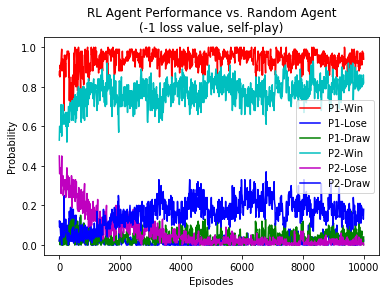

----------------------------
|        |        |        |
|--------------------------|
|        |        |        |
|--------------------------|
|        |        |        |
----------------------------
Your move? i.e. x,y : 2,2
----------------------------
| -1.000 | -1.000 | -0.985 |
|--------------------------|
| -0.010 | 0.000  | -0.985 |
|--------------------------|
| -0.970 | -0.955 |   X    |
----------------------------
>>>>>>> Best action: (1, 1)
----------------------------
|        |        |        |
|--------------------------|
|        |   O    |        |
|--------------------------|
|        |        |   X    |
----------------------------
Your move? i.e. x,y : 1,1
----------------------------
| 0.500  | 0.500  | 0.500  |
|--------------------------|
| 0.500  |   X    | 0.500  |
|--------------------------|
| 0.500  | 0.500  |   X    |
----------------------------
>>>>>>> Best action: (0, 0)
----------------------------
|   O    |        |        |
|---------------------

In [ ]:
if __name__ == "__main__":
    p1 = Agent(1, lossval = -1)
    p2 = Agent(2, lossval = -1)
    r1 = Agent(1, learning = False)
    r2 = Agent(2, learning = False)
    r1.epsilon = 1
    r2.epsilon = 1
    series = ['P1-Win','P1-Lose','P1-Draw','P2-Win','P2-Lose','P2-Draw']
    colors = ['r','b','g','c','m','b']
    markers = ['+', '.', 'o', '*', '^', 's']
    f = open('results.csv', 'w')
    writer = csv.writer(f)
    writer.writerow(series)
    perf = [[] for _ in range(len(series) + 1)]
    for i in range(10000):
        if i % 10 == 0:
            print('Game: {0}'.format(i))
            probs = measure_performance_vs_random(p1, p2)
            writer.writerow(probs)
            f.flush()
            perf[0].append(i)
            for idx,x in enumerate(probs):
                perf[idx+1].append(x)
        winner = play(p1,p2)
        p1.episode_over(winner)
        #winner = play(r1,p2)
        p2.episode_over(winner)
    f.close()
    for i in range(1,len(perf)):
        plt.plot(perf[0], perf[i], label=series[i-1], color=colors[i-1])
    plt.xlabel('Episodes')
    plt.ylabel('Probability')
    plt.title('RL Agent Performance vs. Random Agent\n({0} loss value, self-play)'.format(p1.lossval))
    plt.legend()
    plt.show()
    plt.savefig('selfplay_random_{0}loss.png'.format(p1.lossval))
    while True:
        p2.verbose = True
        p1 = Human(1)
        winner = play(p1,p2)
        p1.episode_over(winner)
        p2.episode_over(winner)